In [3]:
import os, sys, time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

sns.set_style("whitegrid")

In [46]:
data_dir = 'LDA_data/Filings_2021/'
ldf = pd.read_csv(data_dir + 'filings_2021_Q1.csv')
ldf['dt_posted_proc'] = ldf['dt_posted'].apply(lambda x: x.split('T')[0])
ldf['dt_posted_proc'] = pd.to_datetime(ldf['dt_posted_proc']) 

In [49]:
ldf['dt_posted_proc'].max()

Timestamp('2024-01-25 00:00:00')

In [44]:
# import pfizer stock data
import yfinance as yf
pfe_yf_tick = yf.Ticker('PFE')
ydf = pfe_yf_tick.history(start = ldf['dt_posted_proc'].min() - pd.Timedelta(weeks = 4)
, end = ldf['dt_posted_proc'].max() + pd.Timedelta(weeks = 4))

In [45]:
ydf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-02-03 00:00:00-05:00,31.069652,31.336038,30.883178,30.936457,38524200,0.0,0.0
2021-02-04 00:00:00-05:00,30.909823,31.149572,30.812147,30.980858,34284900,0.0,0.0
2021-02-05 00:00:00-05:00,31.007494,31.149571,30.883180,31.007494,31749600,0.0,0.0
2021-02-08 00:00:00-05:00,31.043011,31.087408,30.847662,30.918697,31633900,0.0,0.0
2021-02-09 00:00:00-05:00,30.900935,31.131806,30.865416,31.051889,30170200,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-14 00:00:00-05:00,27.010000,27.170000,26.910000,27.110001,25270200,0.0,0.0
2024-02-15 00:00:00-05:00,27.250000,27.809999,27.219999,27.510000,36111600,0.0,0.0
2024-02-16 00:00:00-05:00,27.549999,27.889999,27.209999,27.620001,35913500,0.0,0.0


In [41]:
ydf_dates_unprocessed = ydf.index.tolist()
ydf_dates = []
for t in ydf_dates_unprocessed:
    ydf_dates.append(
        str(t.year) + '-' + str.format("{:02d}", t.month) + '-' + str.format("{:02d}", t.day)
    )
ydf['Date'] = ydf_dates
ydf['Date'] = pd.to_datetime(ydf['Date'])

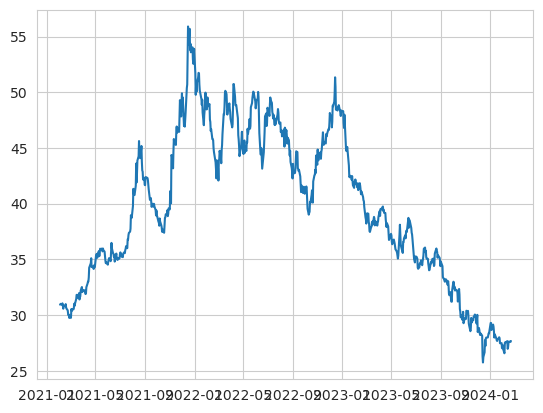

In [43]:
plt.plot(ydf['Date'], ydf['Close'])

In [5]:
data_dir = 'LDA_data/Filings_2020/'
df = pd.read_csv(data_dir + 'filings_2020_Q4.csv', parse_dates = ['dt_posted'])

In [5]:
# some column elements are formatted as strings containing a list object
# process it so that the elements are lists

# example
string = df['lobbying_activities'][0]
print(string)
print(type(string))

# use ast.literal_eval to convert string of list to list
import ast
list_from_string = ast.literal_eval(string) # convert string of list to list
print(list_from_string)
print(type(list_from_string))

[{'general_issue_code': 'CPI', 'general_issue_code_display': 'Computer Industry', 'description': 'Cyber Commerce is looking to expand their market into the Government space.', 'foreign_entity_issues': '', 'lobbyists': [{'lobbyist': {'id': 58543, 'prefix': None, 'prefix_display': None, 'first_name': 'DANIEL', 'nickname': None, 'middle_name': None, 'last_name': 'MCKEON', 'suffix': None, 'suffix_display': None}, 'covered_position': 'Managing Partner', 'new': False}], 'government_entities': [{'id': 2, 'name': 'HOUSE OF REPRESENTATIVES'}]}, {'general_issue_code': 'DEF', 'general_issue_code_display': 'Defense', 'description': 'Cyber Commerce is looking to expand their market into the government space.', 'foreign_entity_issues': '', 'lobbyists': [{'lobbyist': {'id': 58543, 'prefix': None, 'prefix_display': None, 'first_name': 'DANIEL', 'nickname': None, 'middle_name': None, 'last_name': 'MCKEON', 'suffix': None, 'suffix_display': None}, 'covered_position': 'Managing Partner', 'new': False}], 

In [6]:
# format columns whose elements are strings, but are used as list or dict objs
keys = ['lobbying_activities', 'client', 'registrant']
for k in tqdm(keys):
    df[k] = df[k].apply(ast.literal_eval)

    # CODE BELOW IS NOT GOOD; LOBBYING ACTIVITIES CAN REPORT ON MORE THAN ONE CATEGORY 
    # no reason for lobbying_activities to be a list with one element, extract dict inside list
    if k == 'lobbying_activities': 
        df[k] = df['lobbying_activities'].apply(lambda x: x[0])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


In [7]:
# format expenses and income NANs to be zero
keys = ['expenses', 'income']
df[keys] = df[keys].fillna(0.)

In [8]:
# let's start filtering the data
dfc = df.copy()

# given time period (covid-19 vaccine delivery), let's see lobbying related to pharmacy
is_pha = (df['lobbying_activities'].apply(lambda x: x['general_issue_code']) == 'PHA')
dfc = dfc[is_pha]

In [9]:
df.income.values

array([    0.,     0.,     0., ..., 20000., 22500., 10000.])

In [10]:
Nrow, Ncol = dfc.shape
expense_arr = np.array( [ dfc.expenses.values[n] for n in range(Nrow) if dfc.expenses.values[n] != 0. ] )
income_arr = np.array( [ dfc.income.values[n] for n in range(Nrow) if dfc.income.values[n] != 0. ] )

Text(0.5, 1.0, 'Cumulative Expenses / Income: = 3625309.0 / 4130500.0')

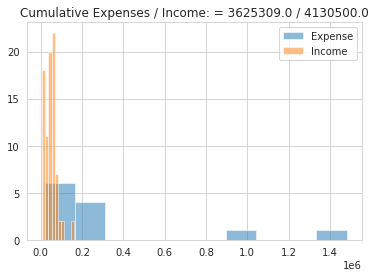

In [11]:
# the following plot shows the total reported expenses / income from lobbying activity from this group
sum_exp = expense_arr.sum()
sum_inc = income_arr.sum()
plt.hist(expense_arr, alpha = 0.5, label = 'Expense')
plt.hist(income_arr, alpha = 0.5, label = 'Income')
plt.legend()
plt.title('Cumulative Expenses / Income: = ' + str(sum_exp) + ' / ' + str(sum_inc) )

In [12]:
is_exp = (dfc['expenses'] != 0.)
dfc_e = dfc[is_exp] ; dfc_i = dfc[~is_exp]

In [13]:
dfc_e['name'] = dfc_e['client'].apply(lambda x: x['name'])
dfc_i['name'] = dfc_i['client'].apply(lambda x: x['name'])

/tmp/ipykernel_2656/3918305093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_e['name'] = dfc_e['client'].apply(lambda x: x['name'])
/tmp/ipykernel_2656/3918305093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_i['name'] = dfc_i['client'].apply(lambda x: x['name'])


In [14]:
print(dfc_i['name'].values)

['IQVIA' 'FCS FOUNDATION' 'OREXO US, INC.' 'VIATRIS INC' 'ALKERMES, INC.'
 'COHERUS BIOSCIENCES' 'OCULAR SCIENCE/OSRX' 'AMPAC FINE CHEMICALS'
 'AMAZON.COM (FRA PILLPACK AN AMAZON COMPANY)' 'PHRMA'
 'TEVA PHARMACEUTICALS USA, INC.' 'AMGEN' 'WALGREEN CO.'
 'EXELA PHARMA SCIENCES' 'TONIX PHARMACEUTICALS'
 'NATIONAL ASSOCIATION OF BOARDS OF PHARMACY' 'CVS HEALTH INC'
 'ALVOGEN, PHARMA US, INC.' 'DYNAVAX TECHNOLOGIES'
 "DR. REDDY'S LABORATORIES, LTD" 'CONSCIOUS DISCIPLINE'
 'LANNETT COMPANY, INC' 'AVET PHARMACEUTICALS' 'ASCENDIS PHARMA, INC.'
 'BLINK HEALTH LTD (A BERMUDA LIMITED COMPANY)'
 'ENDO PHARMACEUTICALS INC.' 'FOUNDATION CONSUMER HEALTHCARE LLC'
 'PHARMACEUTICAL INDUSTRY LABOR MANAGEMENT ASSOCIATION (PILMA)'
 'BLUE SHIELD OF CALIFORNIA' 'VANDA PHARMACEUTICALS INC.' '340B HEALTH'
 'SUMITOMO PHARMA AMERICA (FORMERLY SUNOVION PHARMACEUTICALS, INC.)'
 'VIATRIS INC' 'SORRENTO THERAPEUTICS, INC.'
 'BOEHRINGER INGELHEIM USA CORPORATION'
 'ALLIANCE FOR PHARMACY COMPOUNDING'
 'CANADIAN INTE

In [15]:
# strange that we don't see any of the big names under this category
# let's add some more categories since Pfizer Inc. performs lobbying under
# other categories (more conditioning would be useful if we fix to a certain sector)

# let's start filtering the data
dfc = df.copy()

# given time period (covid-19), let's see lobbying related to pharmacy
is_code = (df['lobbying_activities'].apply(lambda x: (x['general_issue_code']) in ['PHA', 'HCR'] ))
dfc = dfc[is_code]

In [16]:
Nrow, Ncol = dfc.shape
expense_arr = np.array( [ dfc.expenses.values[n] for n in range(Nrow) if dfc.expenses.values[n] != 0. ] )
income_arr = np.array( [ dfc.income.values[n] for n in range(Nrow) if dfc.income.values[n] != 0. ] )

Text(0.5, 1.0, 'Cumulative Expenses / Income: = 59551769.0 / 59489672.0')

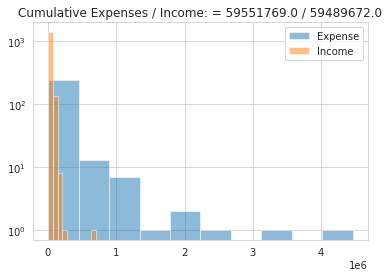

In [17]:
# the following plot shows the total reported expenses / income from lobbying activity from this group
sum_exp = expense_arr.sum()
sum_inc = income_arr.sum()
plt.hist(expense_arr, alpha = 0.5, label = 'Expense', log = True)
plt.hist(income_arr, alpha = 0.5, label = 'Income', log = True)
plt.legend()
plt.title('Cumulative Expenses / Income: = ' + str(sum_exp) + ' / ' + str(sum_inc) )

In [18]:
dfc['name'] = dfc['client'].apply(lambda x: x['name'])
dfc['name']

1        THE PICARD GROUP OBO EMERGENCY CARE PARTNERS, LLC
10                     HANDCRAFTED SOAP AND COSMETIC GUILD
12                     ILLINOIS HOMECARE & HOSPICE COUNCIL
24                                          DOUGLAS COUNTY
28       HADASSAH, THE WOMEN'S ZIONIST ORGANIZATION OF ...
                               ...                        
15567                                     EPIGENOMICS INC.
15579    OKLAHOMA STATE UNIVERSITY CENTER FOR HEALTH SC...
15585                                            HC LOGICS
15587               UNIVERSITY HOSPITAL-NEWARK, NEW JERSEY
15589                  PRIMO CENTER FOR WOMEN AND CHILDREN
Name: name, Length: 2021, dtype: object

In [19]:
# given time period (covid-19), let's see lobbying related to pharmacy
is_pfizer = ( dfc['name'] == 'PFIZER, INC.')
dfc = dfc[is_pfizer]

In [20]:
dfc['expenses']

13811    0.0
Name: expenses, dtype: float64